In [3]:
import sys
sys.path.append('../')

from tqdm import tqdm

import torch as tc
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from torch.distributions.multivariate_normal import MultivariateNormal

from rcgp.rcgp import SpatioTemporalRCGP

from rcgp.kernels import Matern32Kernel

from data.simulations import spatio_temporal_half_contaminated

In [4]:
def plot(idx, grid, ts, pred, Ys, Ys_no_outliers, outliers_loc, true_Ys, n_lon, n_lat):

    x,y = grid[:, 0], grid[:, 1]
    X = x.reshape(n_lon, n_lat)
    Y = y.reshape(n_lon, n_lat)
    
    pred = pred[idx].reshape(n_lon, n_lat)
    Ys = Ys[idx].reshape(n_lon, n_lat)
    Ys_no_outliers = Ys_no_outliers[idx].reshape(n_lon, n_lat)
    true_Ys = true_Ys[idx].reshape(n_lon, n_lat)


    fig, axs = plt.subplots(1, 3, figsize=(12,3))
    kwargs = {"levels" : 10, "cmap": "YlGnBu"}

    outliers_loc_t = outliers_loc[np.where(np.isclose(outliers_loc[:, 0], ts[idx]))]

    axs[0].contourf(X, Y, pred, **kwargs)
    axs[1].contourf(X, Y, Ys_no_outliers, **kwargs)
    axs[1].scatter(outliers_loc_t[:, 1], outliers_loc_t[:, 2], marker='.', s=30., color='red')
    axs[2].contourf(X, Y, true_Ys, **kwargs)
    
    axs[0].set_title("Prediction")
    axs[1].set_title("Data")
    axs[2].set_title("True Latent Function")

    print("Mean Absolute Difference (Data - No Outliers) : ", np.abs(Ys_no_outliers - true_Ys).sum().item())
    print("Mean Absolute Difference (Prediction) : ", np.abs(pred - true_Ys).sum().item())

    return

In [63]:

def conditional_gaussian(mean, cov, idx, y):
    f_i = mean[idx]
    f_minus_i = tc.cat((mean[:idx], mean[idx+1:]))
    S_ii = cov[idx, idx]
    S_i_minus_i = tc.cat((cov[idx, :idx], cov[idx, idx+1:]), dim=0)
    S_minus_i_minus_i = tc.cat(
        (tc.cat((cov[:idx, :idx], cov[:idx, idx+1:]), dim=1),
         tc.cat((cov[idx+1:, :idx], cov[idx+1:, idx+1:]), dim=1)),
        dim=0
    )
    S_minus_i_minus_i_inv = tc.linalg.inv(S_minus_i_minus_i + 1e-6 * tc.eye(S_minus_i_minus_i.shape[0]))
    conditional_mean = f_i + S_i_minus_i @ S_minus_i_minus_i_inv @ (y[tc.arange(len(y)) != idx] - f_minus_i)
    conditional_variance = S_ii - S_i_minus_i @ S_minus_i_minus_i_inv @ S_i_minus_i.T 

    if conditional_variance.ndim==0 : 
        conditional_variance=conditional_variance.reshape(-1,1)

    return conditional_mean, conditional_variance


def compute_weighted_temporal_from_conditionals(mean, cov, y, weights):
    n = len(mean)
    log_sum_density = []
    for i in range(n):
        if i == 0:
            log_sum_density.append(-0.5 * weights[0] * ( (mean[0] - y[0])**2 / cov[0,0] + tc.log(2 * tc.pi * cov[0,0]) ))

        else:
            conditional_mean, conditional_variance = conditional_gaussian(mean[:i+1], cov[:i+1, :i+1], i, y[:i+1])
            eps = (y[i] - conditional_mean).reshape(-1,1)
            conditional_variance = tc.abs(conditional_variance)
            
            
            log_sum_density.append( -0.5 * weights[i] * ( (eps @ tc.linalg.inv(conditional_variance) @ eps.T).squeeze()  + tc.logdet(2 * tc.pi * conditional_variance) ))
    return tc.stack(log_sum_density).mean()

In [71]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):
    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    Ws = (Ws / Ws.sum()).squeeze()
    
    return energies.sum()

def weighted_score_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):
    Ws = Ws/Ws.sum()
    score = tc.tensor(0.0)
    for k in range(Ys.shape[0]):
        score+=compute_weighted_temporal_from_conditionals(mean=preds[k], cov=covs[k], y=Ys[k], weights=Ws[k])
    return score

In [68]:
ts, grids, Ys, true_Ys, Ys_no_outliers, outliers_loc, n_lon, n_lat, lon_norm, lat_norm = spatio_temporal_half_contaminated()

100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


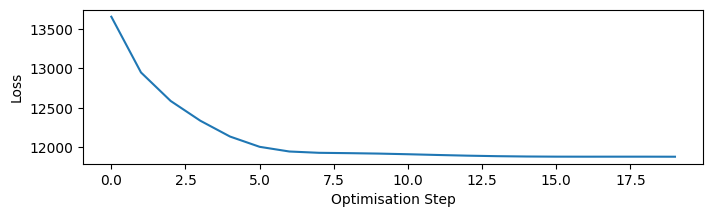

In [95]:
gp = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys_no_outliers, p=1)

gp.activate_robustness(func="constant") 
gp.c=1.
gp._K_w_lengthscale = 1.

losses = []
n_steps = 20
lr = 0.5

weighted_loss = False

optimizer = tc.optim.Adam(gp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp.forward(smoothing=False)
    if weighted_loss:
        loss = weighted_score_rule(Ys=Ys, preds=preds, covs=covs, R=R, Ws=Ws)
    else:
        loss = scoring_rule(Ys=Ys, preds=preds, covs=covs, R=R, Ws=Ws)
    #loss = tc.abs(preds - true_Ys).sum()
    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [96]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)

    print(tc.abs(preds_smooth - true_Ys.squeeze(-1)).sum())

tensor(8930.9551)


Mean Absolute Difference (Data - No Outliers) :  101.3565444946289
Mean Absolute Difference (Prediction) :  1119.8011474609375
Mean Absolute Difference (Data - No Outliers) :  97.08243560791016
Mean Absolute Difference (Prediction) :  1054.118896484375
Mean Absolute Difference (Data - No Outliers) :  98.51832580566406
Mean Absolute Difference (Prediction) :  870.9686889648438
Mean Absolute Difference (Data - No Outliers) :  100.95301818847656
Mean Absolute Difference (Prediction) :  839.12060546875
Mean Absolute Difference (Data - No Outliers) :  93.23451232910156
Mean Absolute Difference (Prediction) :  815.7344360351562
Mean Absolute Difference (Data - No Outliers) :  97.20365142822266
Mean Absolute Difference (Prediction) :  795.1715087890625
Mean Absolute Difference (Data - No Outliers) :  100.76924896240234
Mean Absolute Difference (Prediction) :  940.3536376953125
Mean Absolute Difference (Data - No Outliers) :  98.46554565429688
Mean Absolute Difference (Prediction) :  912.75274

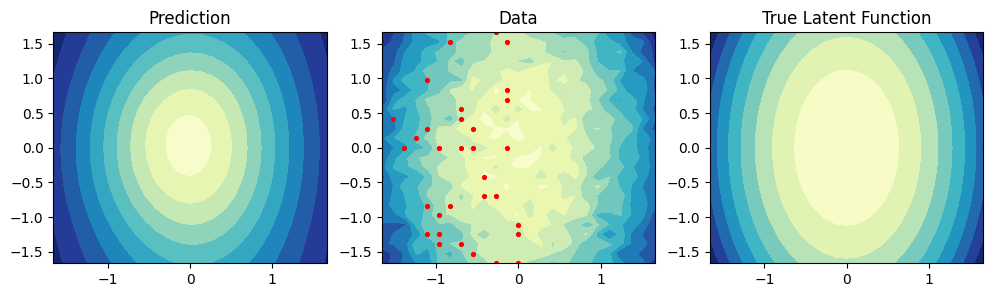

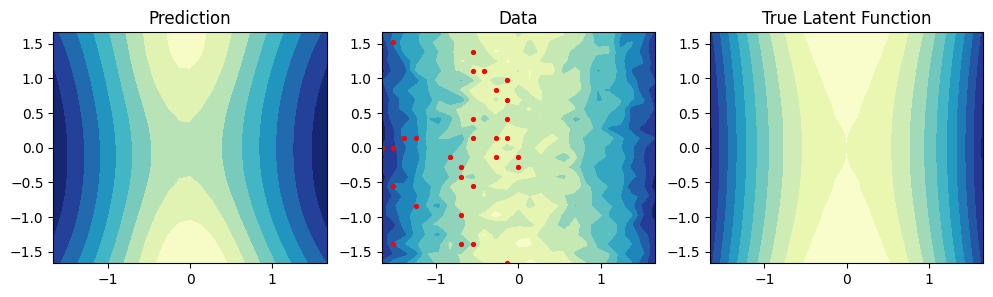

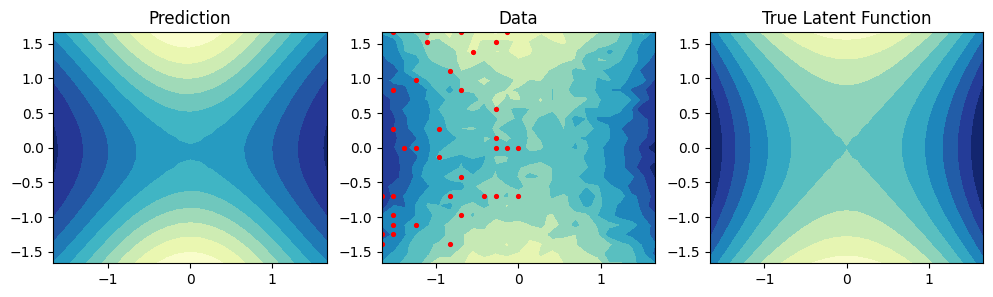

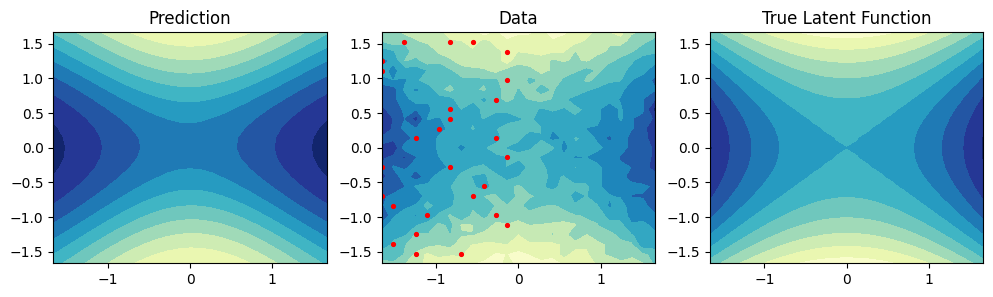

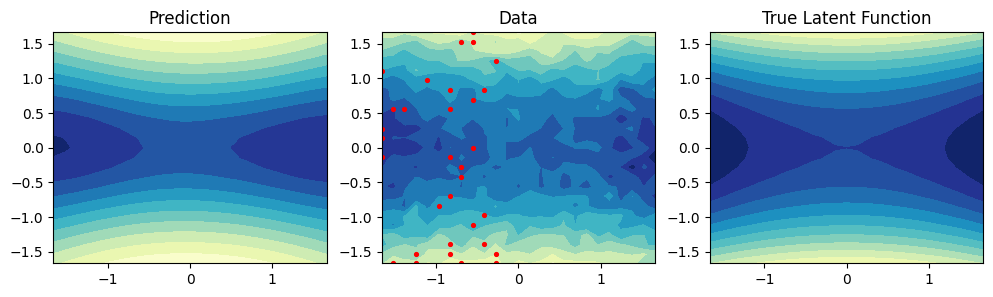

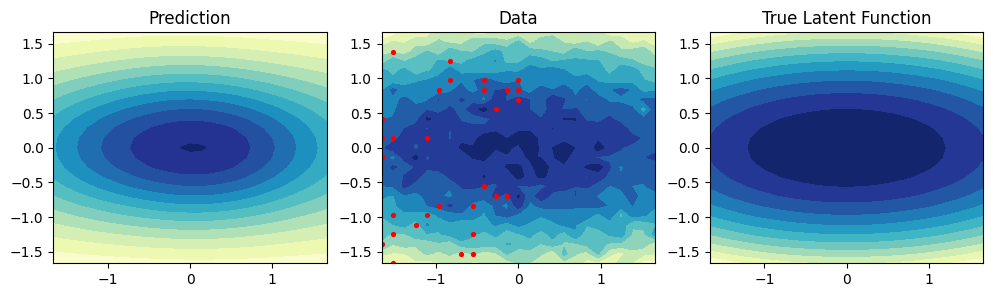

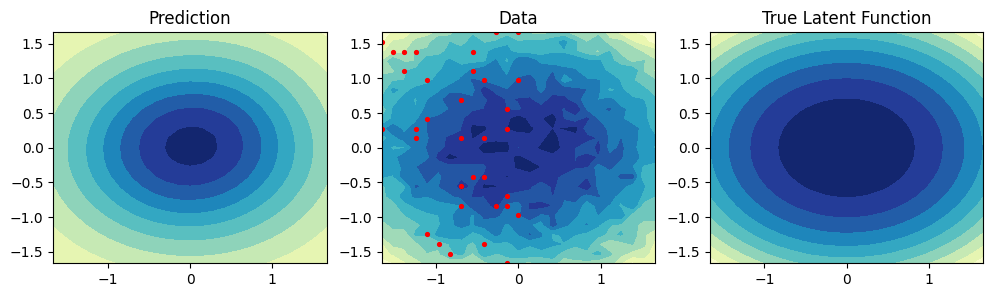

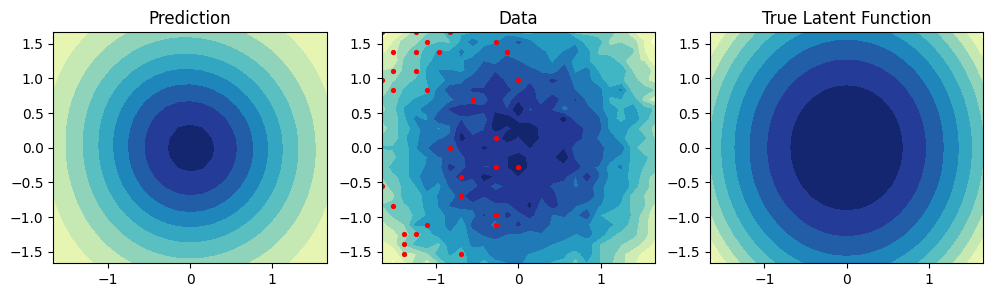

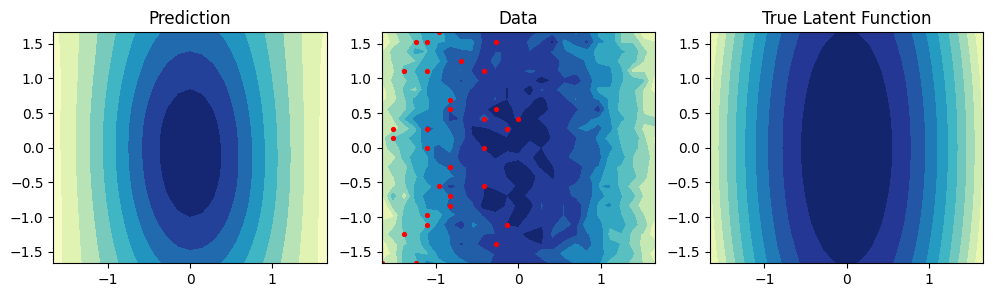

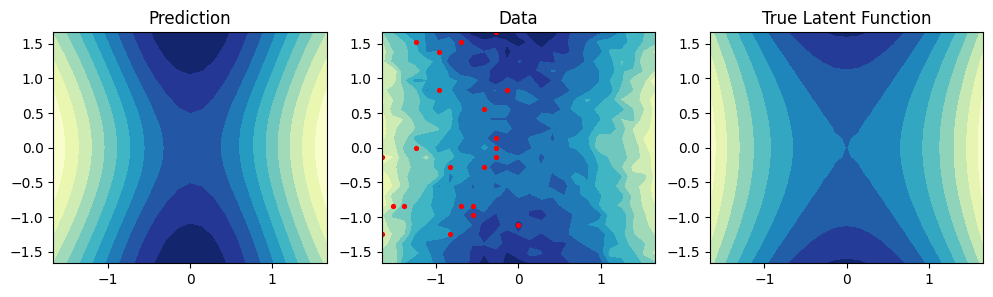

In [97]:
for i in range(10):
    plot(idx=i, grid=grids[0], ts=ts, pred=preds_smooth, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)